# IPBME6UE: Problem Set 2 - Medical Image Processing

## Spring 2023

## Group Members

**Person 1:**

Henrik Sainio

**Person 2:**

Daniel Netzl

Welcome to Problem Set 2!

In this problem set, we will be exploring some fundamental concepts in digital image processing and will perform segmentation and classification of tumors and leisons in imaging.

Breast cancer (BC) is the most commonly diagnosed malignant disease and [the leading cause of cancer death in women in Austria](https://pubmed.ncbi.nlm.nih.gov/35487918/).

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, or at least in our course..."

Treat this as a mini-project. We highly encourage working with 1 other person.


## Problem 1: Image Segmentation (30 points)


Download the [segmentation dataset (~200 MB)](https://imcfhkrems.sharepoint.com/:u:/r/teams/LV_62825/Class%20Materials/Exercise%202/Dataset_BUSI_with_GT.zip?csf=1&web=1&e=fpNqjR).

The dataset is divided into benign, malignant, and normal ultrasound imaging with binary masking.

**a.** Your first task is to segment the images. You may use any of the segmentation algorithms we saw in class. You can ignore the tumor-type division and use all the images but keep track of the method's performance per tumor type for the report in the next section. For the adventurist in you, try using deep learning to generate an initial ROI and active contours to shape that initial ROI into the final segmentation contour. Evaluate your results using an appropriate segmentation metric compared to the ground-truth labels as the target.


In [122]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
from keras.models import Sequential
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam

# define the FCN model
def create_fcn(input_shape=(256,256,1)):
    model = Sequential()
    
    # encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # decoder
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    return model

# Define DICE loss function
def dice_loss(y_true, y_pred):
    # calculate the numerator of the DICE coefficient formula
    numerator = 2 * K.sum(y_true * y_pred, axis=(1, 2, 3))
    # calculate the denominator of the DICE coefficient formula
    denominator = K.sum(y_true + y_pred, axis=(1, 2, 3))
    # calculate the DICE loss
    return 1 - K.mean(numerator / denominator)

# Define JACCARD loss function
def jaccard_loss(y_true, y_pred):
    # calculate the intersection of the true and predicted masks
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    # calculate the union of the true and predicted masks
    union = K.sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    # calculate the JACCARD loss
    return 1 - K.mean(intersection / union)

# Define combined loss function
def dice_jaccard_loss(y_true, y_pred):
    # calculate the sum of DICE and JACCARD losses
    return dice_loss(y_true, y_pred) + jaccard_loss(y_true, y_pred)


# compile the model
model = create_fcn()
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_jaccard_loss, metrics=[dice_loss, jaccard_loss])
# the model performed way better with the following loss function:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
######################################################################################################

In [288]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import jaccard_score, f1_score

# function to load and preprocess the dataset
def load_data(split_classes=False):
    images = []
    masks = []
    
    if split_classes:
        image_dict = {}
        mask_dict = {}

    # Loop through each subdirectory in the dataset directory
    for tumor_type in os.listdir(data_dir):
        tumor_type_dir = os.path.join(data_dir, tumor_type)
        # Loop through each image file in the tumor type subdirectory
        for filename in os.listdir(tumor_type_dir):
            # Check if the file is an image file in PNG format
            if filename.endswith('.png'):
                # Check if the file is a mask image or not
                if "mask" not in filename:
                    # Save image and mask directory (only first mask considered)
                    img_path = os.path.join(tumor_type_dir, filename)
                    mask_path = os.path.join(tumor_type_dir, filename.split(".png")[0] + "_mask.png")
                    # Open the image and mask files, convert to grayscale, and resize to the specified dimensions
                    img = Image.open(img_path).convert('L').resize((img_width, img_height))
                    mask = Image.open(mask_path).convert('L').resize((img_width, img_height))

                    # normalize the image and mask pixel values to [0, 1]
                    img = np.array(img) / 255.0
                    mask = np.array(mask) / 255.0
                    
                    # Append the image and mask arrays to their respective lists
                    images.append(img)
                    masks.append(mask)
                    
        if split_classes:
            image_dict[tumor_type] = np.array(images)
            mask_dict[tumor_type] = np.array(masks)
    
    if split_classes:
        return image_dict, mask_dict

    # convert the images and masks to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    # split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val

In [124]:
# define the dataset directory and image dimensions
data_dir = 'data\\Dataset_BUSI_with_GT'
img_height, img_width = 256, 256

# load the dataset
X_train, X_val, y_train, y_val = load_data()

# data augmentation for the training set
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

# data augmentation for the validation set
val_datagen = ImageDataGenerator()

# define the batch size and number of epochs
batch_size = 16
epochs = 50

# define the model checkpoint to save the best model weights
checkpoint = ModelCheckpoint('fcn_best_weights.h5', save_best_only=True, save_weights_only=True, mode='min', verbose=1)

# train the model
history = model.fit(train_datagen.flow(np.expand_dims(X_train, axis=-1), np.expand_dims(y_train, axis=-1), batch_size=batch_size),
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=epochs,
                              validation_data=val_datagen.flow(np.expand_dims(X_val, axis=-1), np.expand_dims(y_val, axis=-1), batch_size=batch_size),
                              validation_steps=len(X_val) // batch_size,
                              callbacks=[checkpoint])

Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 1.8017 - dice_loss: 0.8746 - jaccard_loss: 0.9271
Epoch 1: val_loss improved from inf to 1.79447, saving model to fcn_best_weights.h5
39/39 [==============================] - 124s 3s/step - loss: 1.8017 - dice_loss: 0.8746 - jaccard_loss: 0.9271 - val_loss: 1.7945 - val_dice_loss: 0.8707 - val_jaccard_loss: 0.9237
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 1.7723 - dice_loss: 0.8575 - jaccard_loss: 0.9148
Epoch 2: val_loss improved from 1.79447 to 1.78614, saving model to fcn_best_weights.h5
39/39 [==============================] - 123s 3s/step - loss: 1.7723 - dice_loss: 0.8575 - jaccard_loss: 0.9148 - val_loss: 1.7861 - val_dice_loss: 0.8663 - val_jaccard_loss: 0.9199
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 1.7871 - dice_loss: 0.8667 - jaccard_loss: 0.9204
Epoch 3: val_loss improved from 1.78614 to 1.76126, saving model to fcn_best_weights.h5
39/39 [===============

1/1 [==============================] - 0s 59ms/step
DICE score:  0.7885935555325818
JACCARD score:  0.6509735515558351


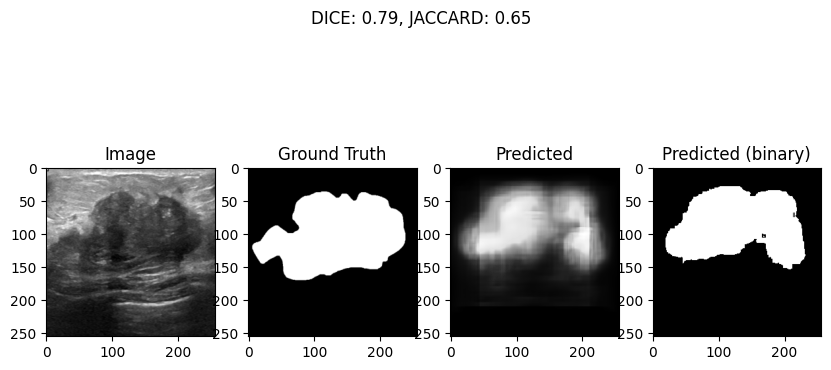

In [281]:
# load the best model weights
from skimage.segmentation import morphological_chan_vese
from numpy import squeeze
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.segmentation import active_contour
import random

# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    # flatten the true and predicted masks
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # calculate the DICE and JACCARD measures
    dice = (2.0 * np.sum(y_true * y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    jaccard = np.sum(y_true * y_pred) / (np.sum(y_true) + np.sum(y_pred) - np.sum(y_true * y_pred))

    return dice, jaccard

model.load_weights('binary_cross_entropy_and_accuracy_fcn_best_weights.h5')
ind = random.randint(1, 210)

# test the model on a sample image
sample_img_dir = data_dir + f'\\malignant\\malignant ({ind}).png'
test_img = Image.open(sample_img_dir).convert('L').resize((img_width, img_height))
test_img = np.array(test_img) / 255.0
test_img = np.expand_dims(test_img, axis=0)
initial_mask = squeeze(model.predict(test_img)[0])

ground_truth_dir = data_dir + f'\\malignant\\malignant ({ind})_mask.png'
ground_truth = Image.open(ground_truth_dir).convert('L').resize((img_width, img_height))
ground_truth = np.array(ground_truth) / 255.0
ground_truth = np.expand_dims(ground_truth, axis=0)

# threshold the predicted mask
thresh = threshold_otsu(initial_mask)
initial_mask_binary = (initial_mask > thresh).astype(np.uint8)

# apply active contours
snake = active_contour(initial_mask, initial_mask_binary, alpha=0.1, beta=1.0, w_line=-1, w_edge=1, gamma=0.1, max_num_iter=2500, convergence=0.1)

# create a mask using the contours
rr, cc = np.round(snake[:, 0]).astype(int), np.round(snake[:, 1]).astype(int)
# test_mask_binary = np.zeros_like(test_mask_binary)
initial_mask_binary[rr, cc] = 1

# evaluate the model
dice, jaccard = evaluate_model(ground_truth, initial_mask_binary)
print("DICE score: ", dice)
print("JACCARD score: ", jaccard)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(test_img.reshape(256, 256), cmap='gray')
axs[0].set_title('Image')
axs[1].imshow(ground_truth.reshape(256, 256), cmap='gray')
axs[1].set_title('Ground Truth')
axs[2].imshow(initial_mask.reshape(256, 256), cmap='gray')
axs[2].set_title('Predicted')
axs[3].imshow(initial_mask_binary.reshape(256, 256), cmap='gray')
axs[3].set_title('Predicted (binary)')

# add the average DICE and JACCARD scores to the plot title
fig.suptitle(f'DICE: {dice:.2f}, JACCARD: {jaccard:.2f}')

# show the plot
plt.show()

In [293]:
# Load split data
image_dict, mask_dict = load_data(split_classes=True)

In [295]:
# test the model on the validation set and calculate the average DICE and JACCARD measures
dice_scores = []
jaccard_scores = []
classes = ["benign", "malignant", "normal"]
for c in classes:
    for i in range(len(image_dict[c])):
        pred_mask = model.predict(np.expand_dims(image_dict[c][i], axis=0), verbose=0)[0]
        # threshold predicted mask
        thresh = threshold_otsu(pred_mask)
        pred_mask = (pred_mask > thresh).astype(np.uint8)
        # evaluate predictions
        dice, jaccard = evaluate_model(mask_dict[c][i], pred_mask)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

    avg_dice = np.mean(dice_scores)
    avg_jaccard = np.mean(jaccard_scores)

    print(f'Average DICE score class {c}:', avg_dice)
    print(f'Average JACCARD score class {c}:', avg_jaccard)

Average DICE score class benign: 0.3376698966647665
Average JACCARD score class benign: 0.235182654432395
Average DICE score class malignant: 0.3825602571501307
Average JACCARD score class malignant: 0.2719428858859146
Average DICE score class normal: 0.3657880325423715
Average JACCARD score class normal: 0.26115738015756773


**b.** Create a report of your segmentation efforts.
Try answering the following questions:

**Which methods did you try? Can you reason your choices?**

FCN neural networks have several advantages over classic, non-deep learning methods for image segmentation tasks, including:
- Ability to learn complex features: FCN networks can automatically learn complex features from images, which is particularly useful for segmentation tasks where traditional methods rely on hand-engineered features.
- End-to-end learning: FCN networks are trained end-to-end, meaning that the entire model is optimized to minimize the segmentation error, rather than separate optimization of different steps in a pipeline. This can lead to better overall performance.
- Flexibility: FCN networks can be applied to a variety of image segmentation tasks and can be easily modified to accommodate different input image sizes and output resolutions.
- Scalability: FCN networks can be trained on large datasets with high variability in the input data, enabling the model to generalize better to new, unseen data.

**Which method worked the best for you? Which method worked the worst? Can you think why?**

**How well did your methods work per class (benign, malignant, and normal)?**
- Benign: DICE 0.338; JACCARD 0.235
- Malignant: DICE 0.383; JACCARD 0.272
- Normal: DICE 0.366; JACCARD 0.261

**Answer:**

## Problem 2: Geometric Features (21 points)

As you may know, the geometric features of a tumor can sometimes reveal significant information about whether it is *benign* or *malignant*. [Radiologists frequently assess the geometry of lesions in mammograms when attempting to diagnose breast cancer](https://www.sciencedirect.com/science/article/pii/S2211568413003872).

In this exercise, we will attempt to explore some quantitative methods of differentiating between certain lesion shapes.

Download the two mammograms from Teams: `LEFT_CC_BENIGN.tif` depicts a cranial-caudal view (looking down on the breast from the patient's perspective) of the left breast. There is a benign lesion present in the mammogram. Can you locate it? 

If you are having difficulty locating the lesion, try seeing if you can spot it in the mask `LEFT_CC_BENIGN_MASK.tif`, which consists of a rough segmentation of the lesion. `RIGHT_CC_MALIGNANT.tif` and `RIGHT_CC_MALIGNANT_MASK.tif` are the mammogram and corresponding lesion segmentation of a different patient, but this mammogram depicts a breast with a **malignant** tumor.

**a.** Start by loading these two mammograms and their corresponding masks as image matrices. 
Plot them on a single figure (e.g., using a 2-by-2 grid of subplots). You should use reasonable **x** and **y** limits in your figures to get a reasonable depiction of your lesion segmentations.

Qualitatively describe the shape differences between the two lesions. What types of shapes and margins are indicative of malignant tumors?

**Answer:**

- The malignant tumor is irregularly shaped, with spiky edges that are not smooth.
- The spiky margins extend outwards from the main body of the tumor.
- The malignant tumors appears as high-density area on the mammogram, indicating that it is denser than the surrounding tissue.

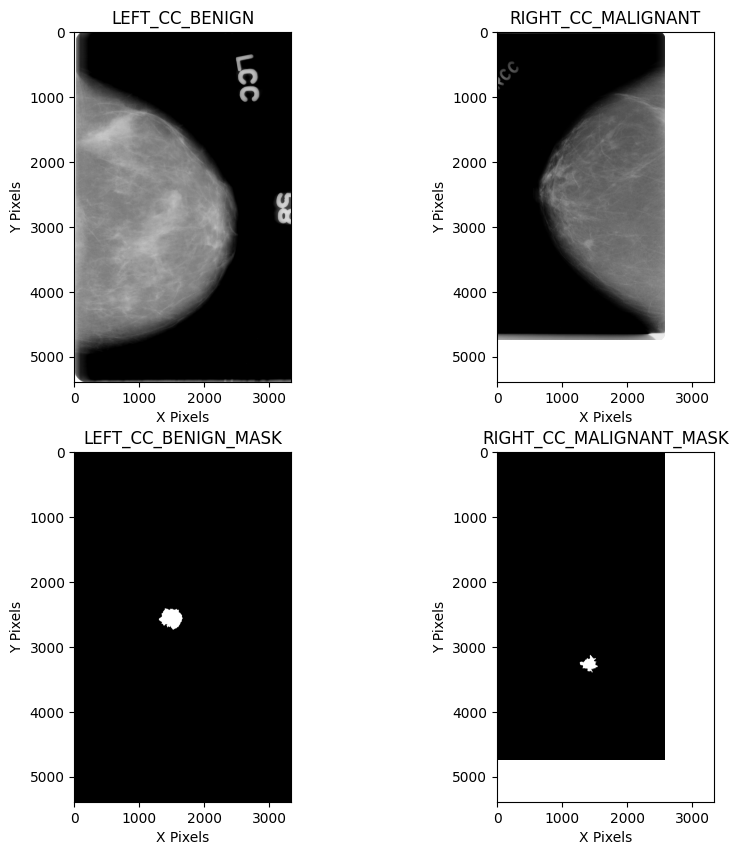

In [9]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_mammograms(mammogram1_path: str, mammogram2_path: str, mask1_path: str, mask2_path: str,
                    figsize: tuple = (10, 10), titles: list = ['Mammogram 1', 'Mammogram 2', 'Mask 1', 'Mask 2']) -> None:
    """
    Load mammogram images and their corresponding masks as numpy arrays, and plot them on a 2x2 grid of subplots.
    
    Parameters:
    mammogram1_path (str): File path of the first mammogram image (.tif).
    mammogram2_path (str): File path of the second mammogram image (.tif).
    mask1_path (str): File path of the mask for the first mammogram image (.tif).
    mask2_path (str): File path of the mask for the second mammogram image (.tif).
    figsize (tuple, optional): Size of the plot figure in inches. Default is (10, 10).
    titles (list, optional): List of titles to assign to each plot.
    """
    # Load the mammogram images and masks as numpy arrays
    mammogram1 = np.array(Image.open(mammogram1_path))
    mammogram2 = np.array(Image.open(mammogram2_path))
    mask1 = np.array(Image.open(mask1_path))
    mask2 = np.array(Image.open(mask2_path))

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # Plot the mammogram images in the top row
    axs[0, 0].imshow(mammogram1, cmap='gray')
    axs[0, 0].set_title(titles[0])
    axs[0, 1].imshow(mammogram2, cmap='gray')
    axs[0, 1].set_title(titles[1])

    # Plot the mask images in the bottom row
    axs[1, 0].imshow(mask1, cmap='gray')
    axs[1, 0].set_title(titles[2])
    axs[1, 1].imshow(mask2, cmap='gray')
    axs[1, 1].set_title(titles[3])

    # Set reasonable x and y limits for the subplots
    for ax in axs.flat:
        ax.set(xlabel='X Pixels', ylabel='Y Pixels', xlim=[0, mammogram1.shape[1]], ylim=[mammogram1.shape[0], 0])

    # Display the figure
    plt.show()
    
mammogram1_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
mask1_path = 'data/LEFT_CC_BENIGN_MASK.tif'
mask2_path = 'data/RIGHT_CC_MALIGNANT_MASK.tif'

plot_mammograms(
    mammogram1_path, 
    mammogram2_path, 
    mask1_path, 
    mask2_path, 
    figsize = (10, 10),
    titles = [x.split("/")[1].split(".")[0] for x in [mammogram1_path, mammogram2_path, mask1_path, mask2_path]])

######################################################################################################


**b.** Next, try computing some basic geometric features of the two lesions. Which features are the most significant for differentiating between them? Is this what you expected? The `regionprops()` function in the `skimage` library will automatically compute several geometric features for you, but you might choose to code up some of your own. If you don't trust the provided segmentations, feel free to create your segmentation method or modify the provided ones to get a better estimate of the lesion shapes! Finally, it could be interesting to apply some edge-detection filters to the mammograms to better emphasize the margins. 

You can also test your approach on other mammograms from a [larger dataset (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH). 

**There is no single correct answer for this exercise, and you should definitely try several different approaches and explore!**

**Answer**:

Malignant vs. benign tumor - important features:
- Solidity 20% lower
- Haralick contrast 34% lower
- the response of the Gabor filters was stronger and more localized in the malignant tumor compared to the benign tumor. This could indicate that the malignant tumor has a more complex and irregular texture, which is a characteristic of cancerous growth.
- Wavelet features all show high differences as well. The results suggest that the malignant tumor has more high-frequency components in the horizontal and vertical directions and fewer diagonal high-frequency components, while the benign tumor has more low-frequency components and more variation in its low-frequency components.

The wavelet and Gabor results were expected, as the tumor shows higher irregularities in texture. Still, the tumor has lower solidity and lower contrast, which was not expected. In general, malignant tumors tend to have irregular shapes and ill-defined margins, which can lead to higher values of solidity and contrast. However, it is important to note that there can be significant variability in the appearance of malignant tumors, and some may exhibit lower solidity and contrast. Therefore, it is important not to rely on a single feature alone. 

In [48]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
from skimage import io, measure, filters
from skimage.feature import graycomatrix, graycoprops
from scipy.fftpack import fft2, fftshift
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import pywt

def rescale_image(img: np.ndarray) -> np.ndarray:
    """
    Rescale an image so that the maximum grayscale value is 255.

    Args:
        img: A NumPy array representing the image.

    Returns:
        A rescaled NumPy array representing the image.
    """
    max_val = np.max(img)
    img_rescaled = (img / max_val) * 255
    img_rescaled = img_rescaled.astype(np.uint8)
    return img_rescaled

def extract_features(mammogram1_path: str, mammogram2_path: str, mask1_path: str, mask2_path: str):
    """
    Extracts geometric and texture features from two mammograms and their corresponding masks.

    Parameters:
        mammogram1_path (str): The file path of the first mammogram.
        mammogram2_path (str): The file path of the second mammogram.
        mask1_path (str): The file path of the mask for the first mammogram.
        mask2_path (str): The file path of the mask for the second mammogram.

    Returns:
        Dictionary containing the following features for each mammogram:
        - Area
        - Perimeter
        - Eccentricity
        - Solidity
        - Haralick texture features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        - Gabor filter features: mean, variance, skewness, kurtosis
        - Wavelet features: standard deviation of coefficients for each level
    """

    # Load the mammograms and masks
    mammogram1 = io.imread(mammogram1_path)
    mammogram2 = io.imread(mammogram2_path)
    mask1 = io.imread(mask1_path)
    mask2 = io.imread(mask2_path)
    
    # Rescale image
    mammogram1, mammogram2, mask1, mask2 = [rescale_image(img) for img in [mammogram1, mammogram2, mask1, mask2]]
    
    # Create a binary mask of the lesion by thresholding the mask
    lesion1 = np.zeros_like(mammogram1)
    lesion1[mask1 > 0] = mammogram1[mask1 > 0]
    lesion2 = np.zeros_like(mammogram2)
    lesion2[mask2 > 0] = mammogram2[mask2 > 0]

    # Compute geometric features using regionprops
    props1 = measure.regionprops(mask1, intensity_image=mammogram1)
    props2 = measure.regionprops(mask2, intensity_image=mammogram2)

    features = {}

    for (prop1, prop2) in zip(props1, props2):
        # Extract geometric features
        area1, perimeter1, eccentricity1, solidity1 = prop1.area, prop1.perimeter, prop1.eccentricity, prop1.solidity
        area2, perimeter2, eccentricity2, solidity2 = prop2.area, prop2.perimeter, prop2.eccentricity, prop2.solidity
        features[f'mammogram1'] = {'area': area1, 'perimeter': perimeter1, 'eccentricity': eccentricity1, 'solidity': solidity1}
        features[f'mammogram2'] = {'area': area2, 'perimeter': perimeter2, 'eccentricity': eccentricity2, 'solidity': solidity2}

        # Apply filters to better visualize the margins
        edge1 = filters.sobel(lesion1)
        edge2 = filters.sobel(lesion2)

        # Apply texture analysis using Haralick features
        glcm1 = graycomatrix(lesion1, [5], [0], 256, symmetric=True, normed=True)
        glcm2 = graycomatrix(lesion2, [5], [0], 256, symmetric=True, normed=True)
        contrast1 = graycoprops(glcm1, 'contrast')[0][0]
        contrast2 = graycoprops(glcm2, 'contrast')[0][0]
        dissimilarity1 = graycoprops(glcm1, 'dissimilarity')[0][0]
        dissimilarity2 = graycoprops(glcm2, 'dissimilarity')[0][0]
        homogeneity1 = graycoprops(glcm1, 'homogeneity')[0][0]
        homogeneity2 = graycoprops(glcm2, 'homogeneity')[0][0]
        asm1 = graycoprops(glcm1, 'ASM')[0][0]
        asm2 = graycoprops(glcm2, 'ASM')[0][0]
        energy1 = graycoprops(glcm1, 'energy')[0][0]
        energy2 = graycoprops(glcm2, 'energy')[0][0]
        correlation1 = graycoprops(glcm1, 'correlation')[0][0]
        correlation2 = graycoprops(glcm2, 'correlation')[0][0]

        features[f'mammogram1']['haralick_contrast'] = contrast1
        features[f'mammogram2']['haralick_contrast'] = contrast2
        features[f'mammogram1']['haralick_dissimilarity'] = dissimilarity1
        features[f'mammogram2']['haralick_dissimilarity'] = dissimilarity2
        features[f'mammogram1']['haralick_homogeneity'] = homogeneity1
        features[f'mammogram2']['haralick_homogeneity'] = homogeneity2
        features[f'mammogram1']['haralick_ASM'] = asm1
        features[f'mammogram2']['haralick_ASM'] = asm2
        features[f'mammogram1']['haralick_energy'] = energy1
        features[f'mammogram2']['haralick_energy'] = energy2
        features[f'mammogram1']['haralick_correlation'] = correlation1
        features[f'mammogram2']['haralick_correlation'] = correlation2

        # Apply Gabor filter and calculate its features
        frequencies = [0.1, 0.5, 1, 5, 10]
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        for freq in frequencies:
            for theta in thetas:
                gabor1 = filters.gabor(lesion1, frequency=freq, theta=theta)[0]
                gabor2 = filters.gabor(lesion2, frequency=freq, theta=theta)[0]
                mean1, var1, skew1, kurt1 = np.mean(gabor1), np.var(gabor1), skew(gabor1.flatten()), kurtosis(gabor1.flatten())
                mean2, var2, skew2, kurt2 = np.mean(gabor2), np.var(gabor2), skew(gabor2.flatten()), kurtosis(gabor2.flatten())
                features[f'mammogram1'][f'gabor_mean_freq{freq}_theta{theta}'] = mean1
                features[f'mammogram2'][f'gabor_mean_freq{freq}_theta{theta}'] = mean2
                features[f'mammogram1'][f'gabor_var_freq{freq}theta{theta}'] = var1
                features[f'mammogram2'][f'gabor_var_freq{freq}theta{theta}'] = var2
                features[f'mammogram1'][f'gabor_skew_freq{freq}theta{theta}'] = skew1
                features[f'mammogram2'][f'gabor_skew_freq{freq}theta{theta}'] = skew2
                features[f'mammogram1'][f'gabor_kurtosis_freq{freq}theta{theta}'] = kurt1
                features[f'mammogram2'][f'gabor_kurtosis_freq{freq}theta{theta}'] = kurt2
        
        # Apply 2D wavelet transform and calculate its features
        # extract approximation (cA), horizontal detail (cH), vertical detail (cV), and diagonal detail (cD)
        coeffs1 = pywt.dwt2(lesion1, 'db2')
        cA1, (cH1, cV1, cD1) = coeffs1
        coeffs2 = pywt.dwt2(lesion2, 'db2')
        cA2, (cH2, cV2, cD2) = coeffs2
        features[f'mammogram1']['wavelet_cA_mean'] = np.mean(cA1)
        features[f'mammogram2']['wavelet_cA_mean'] = np.mean(cA2)
        features[f'mammogram1']['wavelet_cA_var'] = np.var(cA1)
        features[f'mammogram2']['wavelet_cA_var'] = np.var(cA2)
        features[f'mammogram1']['wavelet_cH_mean'] = np.mean(cH1)
        features[f'mammogram2']['wavelet_cH_mean'] = np.mean(cH2)
        features[f'mammogram1']['wavelet_cH_var'] = np.var(cH1)
        features[f'mammogram2']['wavelet_cH_var'] = np.var(cH2)
        features[f'mammogram1']['wavelet_cV_mean'] = np.mean(cV1)
        features[f'mammogram2']['wavelet_cV_mean'] = np.mean(cV2)
        features[f'mammogram1']['wavelet_cV_var'] = np.var(cV1)
        features[f'mammogram2']['wavelet_cV_var'] = np.var(cV2)
        features[f'mammogram1']['wavelet_cD_mean'] = np.mean(cD1)
        features[f'mammogram2']['wavelet_cD_mean'] = np.mean(cD2)
        features[f'mammogram1']['wavelet_cD_var'] = np.var(cD1)
        features[f'mammogram2']['wavelet_cD_var'] = np.var(cD2)

    return pd.DataFrame(features)
######################################################################################################

In [49]:
mammogram1_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
mask1_path = 'data/LEFT_CC_BENIGN_MASK.tif'
mask2_path = 'data/RIGHT_CC_MALIGNANT_MASK.tif'

# Display all rows of a DataFrame
pd.set_option('display.max_rows', None)

geometric_features = extract_features(mammogram1_path, mammogram2_path, mask1_path, mask2_path)
geometric_features['percent_diff'] = ((geometric_features['mammogram2'] - geometric_features['mammogram1']) / geometric_features['mammogram1']) * 100
geometric_features

,mammogram1,mammogram2,percent_diff
area,79149.000000,35508.000000,-55.137778
perimeter,1696.481456,1499.284451,-11.623882
eccentricity,0.477206,0.484424,1.512614
solidity,0.891790,0.716884,-19.612833
haralick_contrast,6.003244,3.967552,-33.909857
haralick_dissimilarity,0.048953,0.044625,-8.840113
haralick_homogeneity,0.996851,0.997558,0.070927
haralick_ASM,0.990934,0.993911,0.300434
haralick_energy,0.995457,0.996951,0.150104
haralick_correlation,0.975317,0.956954,-1.882797


**c.** Computing GLCMs over the entire image is generally not very useful. Any subtle changes in lesion texture could make a significant difference in terms of the radiologist's diagnosis, but it might only result in a minimal change in the image's GLCM. A simple solution is to break the image down into chunks and compute a localized GLCM of each image chunk.

Try doing this on *one* of the provided mammograms. Iterate through the full mammogram and extract overlapping chunks (similar to what you would do when computing a 2D convolution), then compute the GLCM of each chunk. From each GLCM, compute your favorite Haralick texture feature and save it to a separate matrix. If you've done this correctly, you should be able to produce a textural feature map that is about the same size as your image. Plot this texture map alongside the original image. Does it look like what you expect? Why or why not?

**Tips:**
1. This could take really long ~ > 10 mins. If your code is taking too long to run, try downsampling the mammogram to a more reasonable size.
2. Don't worry too much about how the kernel behaves near the edges of the image, since these image regions are generally not as important.
3. You can choose whatever offsets you'd like when computing the GLCM. It is typical for researchers to make their textural features rotation-invariant by averaging features from multiple GLCMs computed using offsets oriented in all directions, and you can choose to do this if you want.
4. Explore different kernel sizes!

**Answer**
We defined several Haralick features to get better texture maps and looking at the second mammograph containing the malignant tumor, the texture map is able to segment the tumor pretty well. Thus, the texture map is useful for identifying areas of similar texture and can be used in image segmentation.

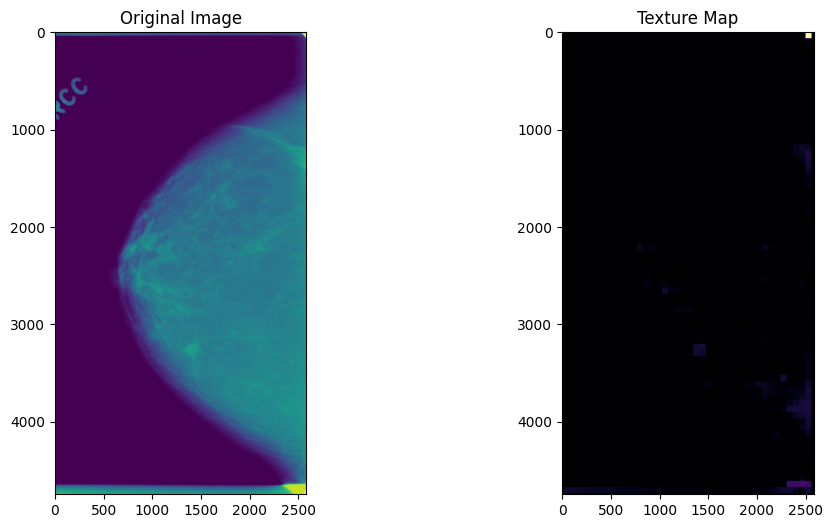

In [91]:
### WRITE CODE IN HERE. You can have up to 3 cells for this question ################################
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util, feature
from skimage.measure import block_reduce
from skimage.feature import graycomatrix, graycoprops

def compute_texture_map(
    image_path: str, 
    chunk_size: int = 64, 
    offsets: tuple = ((1, 0), (0, 1)), 
    haralick_features: list = ['contrast', 'correlation', 'energy', 'homogeneity'],
    downsample: bool = True) -> np.ndarray:
    """
    Compute and plot texture maps of an image in a chunk-wise manner using GLCMs.

    Parameters
    ----------
    image_path : str
        Path to the input image file.
    chunk_size : int, optional
        Size of the chunks to divide the image into (in pixels). Default is 64.
    offsets : tuple, optional
        Offsets of the GLCM calculation. Default is ((1, 0), (0, 1)) for horizontal and vertical directions.
    haralick_features : list, optional
        Haralick texture features to compute for each GLCM. Default is ['contrast', 'correlation', 'energy', 'homogeneity'].
    downsample : bool, optoinal
        Boolean value whether to downsample the image.

    Returns
    -------
    numpy.ndarray
        Texture map of the input image in a chunk-wise manner. The shape of the texture map is (n_rows, n_cols).
    """

    # Load the input image
    image = io.imread(image_path)
    
    # Rescale the image to be between -1 and 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 2 - 1

    # Downsample the image to speed up processing
    if downsample:
        image = util.img_as_ubyte(block_reduce(image, (4, 4), np.mean))
    else:
        image = util.img_as_ubyte(image)
    
    # Determine maximum gray level
    max_gray_level = int(np.max(image))
    
    # Compute the number of chunks in each dimension
    n_rows = image.shape[0] // chunk_size
    n_cols = image.shape[1] // chunk_size
    
    # Create a matrix to store the texture features
    texture_map = np.zeros(image.shape)
    
    # Iterate over each chunk
    for i in range(n_rows):
        for j in range(n_cols):
            
            # Define the coordinates of the current chunk
            row_start = i * chunk_size
            row_end = (i + 1) * chunk_size
            col_start = j * chunk_size
            col_end = (j + 1) * chunk_size
            
            # Extract the current chunk
            chunk = image[row_start:row_end, col_start:col_end]
            
            # Compute the GLCM of the current chunk for each offset and concatenate them
            glcms = []
            for offset in offsets:
                glcm = graycomatrix(chunk, distances=[1], angles=[np.arctan2(offset[0], offset[1])], levels=max_gray_level+1,
                                    symmetric=True, normed=True)
                glcms.append(glcm)
            glcm_concat = np.concatenate(glcms, axis=0)
            
            # Compute the Haralick texture features for the concatenated GLCM
            texture_features = [graycoprops(glcm, feature) for feature in haralick_features for glcm in glcms]
            
            # Store the texture feature in the texture map matrix
            texture_map[row_start:row_end, col_start:col_end] = texture_features[0]
    
    return texture_map

mammogram1_path = 'data/LEFT_CC_BENIGN.tif'
mammogram2_path = 'data/RIGHT_CC_MALIGNANT.tif'
texture_map = compute_texture_map(mammogram2_path, chunk_size=64, downsample=False)
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].imshow(io.imread(mammogram2_path))
ax[0].set_title('Original Image')
ax[1].imshow(texture_map, cmap='inferno')
ax[1].set_title('Texture Map')
plt.show()
######################################################################################################

## Problem 3: Tumor Classification (49 Points)

In addition to the [mammograms themselves (~20 GB)](https://imcfhkrems.sharepoint.com/:f:/r/teams/LV_62825/Class%20Materials/Exercise%202?csf=1&web=1&e=X41LBH), which is based on [this](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Research done about the fields:
- "ground truth": segmentations including precise delination of the location and size of the massess in the mammography done by experienced radiologists. Serves as benchmark for the eevelopment and evaluation of automated algorithms for detecting and calssifying breast masses.
- mass shape: the shape of the mass (round, oval, lobular, irregular)
- mass margins: the margins of the mass (circumscribed, microlobulated, obscured, ill-defined, spiculated)
- assessment: BI-RADS assessment code associated with the mass (1-5)
- pathology: the pathology diagnosis for the mass (benign, malignant, high-risk, or uncertain malignant potential)
- subtlety: the level of difficulty in detecting the mass on a scale of 1 to 5, with 1 being the least subtle and 5 being the most subtle.


Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on these feature table using the algorithms presented to you last year in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any package or use your own (custom code, sklearn, keras, Tensorflow, pytorch, timm etc.). If you dont want to place helper functions and classes into this notebook, place them in a .py file in the same folder called helperfunctions.py and import them into this notebook.

The delivery should be a report which includes the experiment planning, the extracted features and the results.
Try answering in your report the following questions:

- Which method(s) did you use? 
- Why did you choose these method(s)?
- What were your expectations towards these methods?
- How did they perform compared to your expectations?
- Which metrics did you use? To which ones did you pay the most attention?
- How do you feel about your results? 
- How would you plan to improve your results further?  

In [ ]:
### WRITE CODE IN HERE. ##############################################################################












######################################################################################################